# Kid-Safe Strict Style Content Reframer

## Fine-tuning an Instruction Model for Child-Friendly Content Rewriting

### Objective
Train a small to mid-size instruction-following model to rewrite news articles into child-friendly formats based on label type:
- **SAFE**: Faithful, factual, kid-vocab summary (short sentences, all core info retained)
- **SENSITIVE**: Reframed educational version (softened content, moral/lesson framing, creative reframing, less faithful but safe)

### Model Strategy
- **Base Model**: Mistral-7B-Instruct (strong instruction-following capabilities)
- **Fine-tuning**: LoRA (Low-Rank Adaptation) for parameter-efficient training

### GPU Configuration
- **GPU**: NVIDIA B200 (170GB VRAM, SM_100, CUDA 12.8)
- **Optimization**: Using bfloat16 precision (no quantization needed with 170GB VRAM)
- **Batch Size**: Optimized for large VRAM capacity


## 1. Setup & Installation


In [1]:
# # For NVIDIA B200 (CUDA 12.8, SM_100), install PyTorch with CUDA 12.4+ support first:
# # Uncomment the line below if PyTorch is not already installed with CUDA support
# # %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# # Install other dependencies
# %pip install -q transformers datasets accelerate peft sentencepiece protobuf
# %pip install -q lm-format-enforcer matplotlib seaborn pandas scikit-learn tqdm
# %pip install -q huggingface_hub pydantic

# # Optional: Flash Attention 2 for faster training (recommended for B200)
# # Uncomment the line below to install Flash Attention 2 (may take several minutes to compile)
# # %pip install flash-attn --no-build-isolation

# # Note: bitsandbytes is NOT installed as it's not needed with 170GB VRAM
# # and may not support SM_100 architecture yet


In [2]:
import gc
import torch

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
def print_detailed_memory():
    print("\n=== Detailed GPU Memory ===")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Cached:    {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    
    # Per-device breakdown if multiple GPUs
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}:")
        print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Cached:    {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
    
    print(f" GPU total memory:   {torch.cuda.get_device_properties(0).total_memory / 1024**3}")
    # System-level GPU info
    if torch.cuda.is_available():
        print(f"GPU Free:   {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()) / 1024**3:.2f} GB available")

print_detailed_memory()


=== Detailed GPU Memory ===
Allocated: 0.00 GB
Cached:    0.00 GB
GPU 0:
  Allocated: 0.00 GB
  Cached:    0.00 GB
 GPU total memory:   178.3616943359375
GPU Free:   178.36 GB available


In [5]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, get_peft_model
from datasets import Dataset as HFDataset

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Setup PROJECT_ROOT
notebook_dir = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(notebook_dir, '..'))
print(f"Project root: {PROJECT_ROOT}")

# Create results directory for this notebook
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results', 'kid_safe_rewriter')
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results directory: {RESULTS_DIR}")

# GPU Configuration for NVIDIA B200
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    # Check if bfloat16 is supported (required for B200)
    if torch.cuda.is_bf16_supported():
        print("✅ bfloat16 is supported - using bf16 for training")
        USE_BF16 = True
    else:
        print("⚠️  bfloat16 not supported - using float16 instead")
        USE_BF16 = False
else:
    print("⚠️  CUDA not available - using CPU (not recommended for training)")
    USE_BF16 = False


Project root: /blue/eee6778/koshyreshma/AI/MiniNewsAI
Results directory: /blue/eee6778/koshyreshma/AI/MiniNewsAI/results/kid_safe_rewriter
PyTorch version: 2.7.1+cu128
CUDA available: True
CUDA device: NVIDIA B200
CUDA version: 12.8
GPU Memory: 191.51 GB
✅ bfloat16 is supported - using bf16 for training


## 2. Data Loading & Exploration


In [6]:
# Load dataset
df = pd.read_csv('../data/raw/stage3_kid_safe_rewriter_input.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (5785, 5)
Columns: ['Unnamed: 0', 'label', 'title', 'article_500', 'rewrite']

First few rows:


,Unnamed: 0,label,title,article_500,rewrite
0,0,SAFE,Man Surprises Girlfriend By Drawing Them In Di...,"Kellen Hickey, 26, drew himself and his girlfr...",Title: Man Surprises Girlfriend By Drawing The...
1,1,SAFE,This Artist Gives Renaissance-Style Sculptures...,Barcelona-based artist Gerard Mas mixes Renais...,Title: This Artist Gives Renaissance-Style Scu...
2,2,SAFE,Sculptures From This International Ice And Sno...,The Harbin International Ice and Snow Festival...,Title: Sculptures From This International Ice ...
3,3,SAFE,60 Books We Can't Wait To Read In 2018,The coming year's literary crop looks bountifu...,Title: 60 Books We Can't Wait To Read In 2018\...
4,4,SAFE,"Why Do We Call That Holiday Game Yankee Swap, ...",Gift exchanges are a big part of American Chri...,Title: Why Do We Call That Holiday Game Yankee...


In [7]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Remove rows with missing values
df = df.dropna()
print(f"\nDataset shape after removing missing values: {df.shape}")


Missing values:
Unnamed: 0     0
label          0
title          0
article_500    0
rewrite        0
dtype: int64

Dataset shape after removing missing values: (5785, 5)


Label distribution:
label
SENSITIVE    3031
SAFE         2754
Name: count, dtype: int64

Label percentages:
label
SENSITIVE    52.394123
SAFE         47.605877
Name: count, dtype: float64


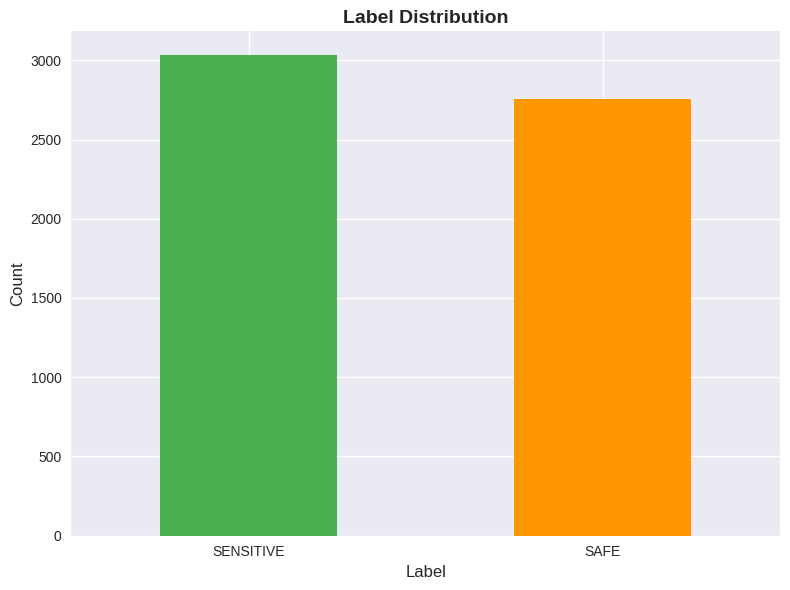

✓ Label distribution saved to: /blue/eee6778/koshyreshma/AI/MiniNewsAI/results/kid_safe_rewriter/label_distribution.png


In [8]:
# Class balance analysis
label_counts = df['label'].value_counts()
print("Label distribution:")
print(label_counts)
print(f"\nLabel percentages:")
print(label_counts / len(df) * 100)

# Visualize class balance
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
label_counts.plot(kind='bar', ax=ax, color=['#4CAF50', '#FF9800'])
ax.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Label distribution saved to: {os.path.join(RESULTS_DIR, 'label_distribution.png')}")


Article length statistics (words):
count    5785.000000
mean      184.710631
std        41.648631
min        73.000000
25%       153.000000
50%       170.000000
75%       225.000000
max       293.000000
Name: article_length, dtype: float64

Rewrite length statistics (words):
count    5785.000000
mean      150.016768
std        42.654976
min         8.000000
25%       124.000000
50%       144.000000
75%       168.000000
max       382.000000
Name: rewrite_length, dtype: float64


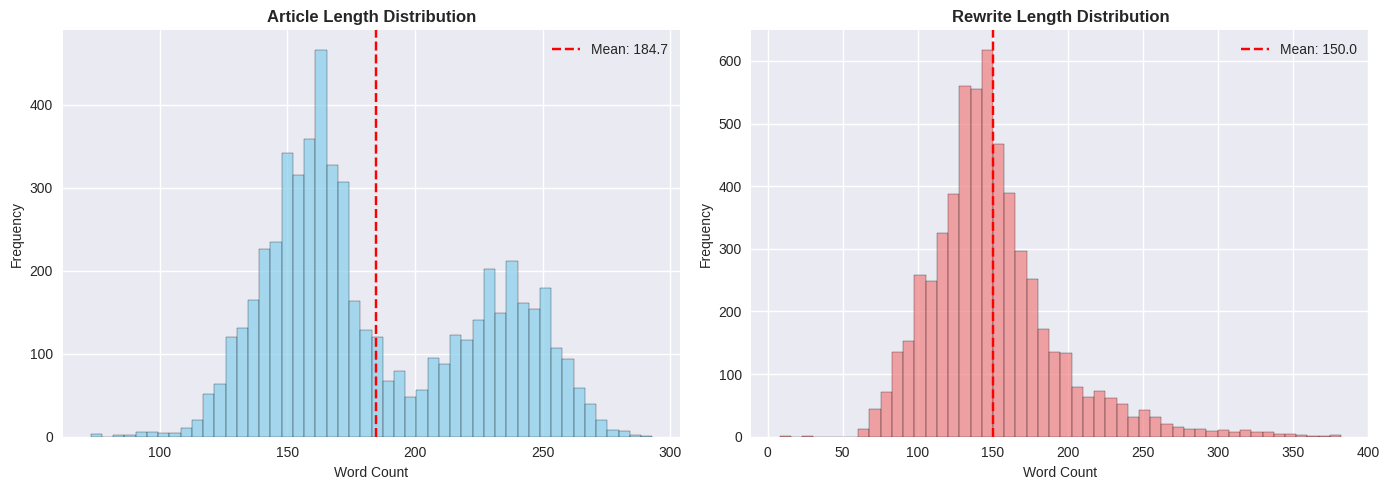

✓ Text length distribution saved to: /blue/eee6778/koshyreshma/AI/MiniNewsAI/results/kid_safe_rewriter/text_length_distribution.png


In [9]:
# Analyze text length statistics
df['article_length'] = df['article_500'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df['rewrite_length'] = df['rewrite'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("Article length statistics (words):")
print(df['article_length'].describe())
print("\nRewrite length statistics (words):")
print(df['rewrite_length'].describe())

# Visualize length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['article_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Article Length Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Word Count', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].axvline(df['article_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["article_length"].mean():.1f}')
axes[0].legend()

axes[1].hist(df['rewrite_length'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_title('Rewrite Length Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Word Count', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].axvline(df['rewrite_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["rewrite_length"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'text_length_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Text length distribution saved to: {os.path.join(RESULTS_DIR, 'text_length_distribution.png')}")


In [10]:
# Sample records for both labels
print("=" * 80)
print("SAFE EXAMPLE")
print("=" * 80)
safe_example = df[df['label'] == 'SAFE'].iloc[0]
print(f"\nTitle: {safe_example['title']}")
print(f"\nArticle:\n{safe_example['article_500'][:400]}...")
print(f"\nRewrite:\n{safe_example['rewrite'][:400]}...")

print("\n" + "=" * 80)
print("SENSITIVE EXAMPLE")
print("=" * 80)
sensitive_example = df[df['label'] == 'SENSITIVE'].iloc[0]
print(f"\nTitle: {sensitive_example['title']}")
print(f"\nArticle:\n{sensitive_example['article_500'][:2000]}...")
print(f"\nRewrite:\n{sensitive_example['rewrite'][:2000]}...")


SAFE EXAMPLE

Title: Man Surprises Girlfriend By Drawing Them In Different Animation Styles

Article:
Kellen Hickey, 26, drew himself and his girlfriend Lindsay Brinkman, 24, in 10 different animation styles. He gave the illustrations to her on Christmas. The couple has framed nine of the photos and have them hanging in their living room. Hickey posted the drawings on his Instagram account earlier this week, where they’ve since gotten a lot of attention online. The “Dragon Ball Z-style drawing was...

Rewrite:
Title: Man Surprises Girlfriend By Drawing Them In Different Animation Styles

A man named Kellen Hickey, who is 26 years old, wanted to make his girlfriend, Lindsay Brinkman, 24, very happy. So, he decided to draw them both in 10 different styles, like how they look in cartoons! He gave the drawings to Lindsay on Christmas. They have nine of the pictures hanging in their...

SENSITIVE EXAMPLE

Title: This Dutch 23-Year-Old Epitomizes The Future Of American Filmmaking

Article:
J

## 3. Data Preprocessing


In [11]:
# Filter out articles/rewrites that are too long (>400 words)
df_filtered = df[(df['article_length'] <= 400) & (df['rewrite_length'] <= 400)].copy()
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size (≤400 words): {len(df_filtered)}")
print(f"Removed: {len(df) - len(df_filtered)} rows")

df = df_filtered


Original dataset size: 5785
Filtered dataset size (≤400 words): 5785
Removed: 0 rows


In [12]:
# Define instruction templates
def create_instruction_prompt(label, article, title):
    """
    Create instruction prompt for fine-tuning.
    
    Args:
        label: SAFE or SENSITIVE
        article: Original article text
        title: Article title
    
    Returns:
        Formatted instruction prompt
    """
    instruction = f"""Instruction: Rewrite the article below into a kid-safe format according to its label ({label}).

Label: {label}

Title: {title}

Input Article:
{article}

Expected Output:"""
    
    return instruction.strip()

# Create instruction prompts
df['instruction'] = df.apply(
    lambda row: create_instruction_prompt(row['label'], row['article_500'], row['title']),
    axis=1
)

# Show example
print("Example instruction prompt:")
print("=" * 80)
print(df['instruction'].iloc[0])
print("=" * 80)


Example instruction prompt:
Instruction: Rewrite the article below into a kid-safe format according to its label (SAFE).

Label: SAFE

Title: Man Surprises Girlfriend By Drawing Them In Different Animation Styles

Input Article:
Kellen Hickey, 26, drew himself and his girlfriend Lindsay Brinkman, 24, in 10 different animation styles. He gave the illustrations to her on Christmas. The couple has framed nine of the photos and have them hanging in their living room. Hickey posted the drawings on his Instagram account earlier this week, where they’ve since gotten a lot of attention online. The “Dragon Ball Z-style drawing was kind of for me,” Hickey said of the “Bob’s Burgers”-style illustration.“None of this would have happened if it weren’t for her, her support and the love between us,’ Hickey told Huffington Post. “As soon as she finished [looking through the drawings she] jump-hugged me and was sure to remind me of how much she loves me for the next hour or so,�” he said of his girlfri

In [13]:
# Target outputs: use the existing rewrites so the model learns each style directly
df['target'] = df['rewrite']
print("Target column created.")


Target column created.


In [14]:
# Train/Validation/Test split
from sklearn.model_selection import train_test_split

# First split: train + (val + test)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']  # Maintain class balance
)

# Second split: val + test
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['label']
)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

print(f"\nTrain label distribution:")
print(train_df['label'].value_counts())
print(f"\nVal label distribution:")
print(val_df['label'].value_counts())
print(f"\nTest label distribution:")
print(test_df['label'].value_counts())


Train set: 4628 samples
Validation set: 578 samples
Test set: 579 samples

Train label distribution:
label
SENSITIVE    2425
SAFE         2203
Name: count, dtype: int64

Val label distribution:
label
SENSITIVE    303
SAFE         275
Name: count, dtype: int64

Test label distribution:
label
SENSITIVE    303
SAFE         276
Name: count, dtype: int64


## 4. Model & Tokenizer Setup


In [15]:
# Model configuration
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"  # Strong instruction model
# Alternative models you can try:
# "google/flan-t5-large" (smaller, faster)
# "meta-llama/Llama-2-7b-chat-hf" (requires HuggingFace access)

print(f"Loading model: {MODEL_NAME}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Set padding token if not exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Tokenizer model max length: {tokenizer.model_max_length}")


Loading model: mistralai/Mistral-7B-Instruct-v0.2
Tokenizer vocab size: 32000
Tokenizer model max length: 1000000000000000019884624838656


In [16]:
# Load model for NVIDIA B200 (170GB VRAM) - No quantization needed!
# Using bfloat16 for optimal performance on B200 (supports tensor cores for bf16)

# Determine dtype based on GPU capabilities
if USE_BF16 and torch.cuda.is_available():
    model_dtype = torch.bfloat16
    print("Loading model with bfloat16 precision (optimal for B200)")
elif torch.cuda.is_available():
    model_dtype = torch.float16
    print("Loading model with float16 precision")
else:
    model_dtype = torch.float32
    print("Loading model with float32 precision (CPU mode)")

# Load model without quantization - full precision with bfloat16
# Note: For Flash Attention 2 support, install: pip install flash-attn --no-build-isolation
# Flash Attention 2 can significantly speed up training on B200
try:
    # Try to use Flash Attention 2 if available
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=model_dtype,
        attn_implementation="flash_attention_2"
    )
    print("✅ Using Flash Attention 2 (faster training)")
except Exception as e:
    # Fallback to SDPA (Scaled Dot Product Attention) if Flash Attention 2 is not available
    print(f"⚠️  Flash Attention 2 not available: {e}")
    print("   Using SDPA instead (still fast on B200)")
    print("   To install Flash Attention 2: pip install flash-attn --no-build-isolation")
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=model_dtype,
        attn_implementation="sdpa"  # SDPA is also optimized for modern GPUs
    )

print("✅ Model loaded successfully!")
print(f"Model dtype: {model.dtype}")
print(f"Model device: {next(model.parameters()).device}")


Loading model with bfloat16 precision (optimal for B200)
⚠️  Flash Attention 2 not available: FlashAttention2 has been toggled on, but it cannot be used due to the following error: the package flash_attn seems to be not installed. Please refer to the documentation of https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2 to install Flash Attention 2.
   Using SDPA instead (still fast on B200)
   To install Flash Attention 2: pip install flash-attn --no-build-isolation


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Model loaded successfully!
Model dtype: torch.bfloat16
Model device: cuda:0


In [ ]:
# LoRA configuration for efficient fine-tuning
# With 170GB VRAM, we can use higher rank for better performance
lora_config = LoraConfig(
    r=32,  # Increased rank for B200 (was 16) - higher rank = better capacity with your VRAM
    lora_alpha=64,  # LoRA alpha parameter (typically 2x rank)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Mistral attention modules
    lora_dropout=0.1,  # Increased from 0.05 for better regularization
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA (no need for prepare_model_for_kbit_training since we're not using quantization)
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

print("\nWhy LoRA?")
print("LoRA (Low-Rank Adaptation) allows us to fine-tune large models efficiently.")
print("With 170GB VRAM, we can use higher rank (r=32) for better model capacity.")
print("LoRA still provides faster training and easier checkpoint management compared to full fine-tuning.")


trainable params: 83,886,080 || all params: 7,325,618,176 || trainable%: 1.1451

Why LoRA?
LoRA (Low-Rank Adaptation) allows us to fine-tune large models efficiently.
With 170GB VRAM, we can use higher rank (r=32) for better model capacity.
LoRA still provides faster training and easier checkpoint management compared to full fine-tuning.


## 5. Dataset Preparation for Training


In [18]:
# Create PyTorch Dataset class
class KidSafeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Create full prompt (instruction + target)
        instruction = row['instruction']
        target = row['target']
        
        # Format for Mistral instruct format
        # Mistral uses [INST] and [/INST] tags
        full_text = f"[INST] {instruction} [/INST]\n\n{target}"
        
        # Tokenize
        encoding = self.tokenizer(
            full_text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        
        # Create labels (same as input_ids, but mask instruction part)
        # We only want to compute loss on the target (rewrite) part
        instruction_enc = self.tokenizer(
            f"[INST] {instruction} [/INST]\n\n",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        labels = encoding['input_ids'].clone()
        inst_len = instruction_enc['input_ids'].shape[1]
        
        # Mask instruction tokens (set to -100 to ignore in loss)
        labels[:, :inst_len] = -100
        
        # Also mask padding tokens
        labels[labels == tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': labels.squeeze(),
        }

# Create datasets
train_dataset = KidSafeDataset(train_df, tokenizer, max_length=512)
val_dataset = KidSafeDataset(val_df, tokenizer, max_length=512)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

# Test a sample
sample = train_dataset[0]
print(f"\nSample input shape: {sample['input_ids'].shape}")
print(f"Sample labels shape: {sample['labels'].shape}")
print(f"Number of non-masked labels: {(sample['labels'] != -100).sum().item()}")


Train dataset size: 4628
Val dataset size: 578

Sample input shape: torch.Size([512])
Sample labels shape: torch.Size([512])
Number of non-masked labels: 202


In [ ]:
# Custom Trainer to track separate losses for SAFE and SENSITIVE
from transformers import TrainerCallback
import os

class LabelAwareTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.safe_losses = []
        self.sensitive_losses = []
    
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Enhanced loss computation with:
        1. Cross-entropy loss for token prediction
        2. Length penalty to encourage complete generations
        3. Label-aware weighting (SENSITIVE may need more training)
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Standard cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction='none')
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        # Compute per-token losses
        token_losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        token_losses = token_losses.view(shift_labels.shape)
        
        # Count valid tokens (not masked)
        valid_mask = (shift_labels != -100).float()
        num_valid_tokens = valid_mask.sum()
        
        if num_valid_tokens > 0:
            # Base loss: mean over valid tokens
            base_loss = (token_losses * valid_mask).sum() / num_valid_tokens
            
            # Length penalty: encourage longer completions
            # Penalize if the sequence is too short (less than 50% of expected length)
            sequence_length = valid_mask.sum(dim=-1).float()  # Length per sample
            avg_length = sequence_length.mean()
            
            # Target length: at least 100 tokens for good completions
            target_length = 100.0
            length_penalty_weight = 0.1  # Small weight to avoid over-penalizing
            
            if avg_length < target_length:
                length_penalty = length_penalty_weight * (target_length - avg_length) / target_length
            else:
                length_penalty = 0.0
            
            # Final loss
            loss = base_loss + length_penalty
        else:
            loss = token_losses.mean()
        
        return (loss, outputs) if return_outputs else loss

# Custom callback for tracking metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.val_losses.append(logs['eval_loss'])

metrics_callback = MetricsCallback()


## 6. Training Configuration & Training Loop


In [ ]:
# Define model directories (before training arguments)
MODEL_BASE_DIR = os.path.join(PROJECT_ROOT, "models", "kid_safe_rewriter")
BEST_MODEL_DIR = os.path.join(MODEL_BASE_DIR, "best_model")
os.makedirs(MODEL_BASE_DIR, exist_ok=True)

# Training arguments optimized for NVIDIA B200 (170GB VRAM)
# With 170GB VRAM, we can use much larger batch sizes

# Determine precision based on GPU capabilities
if USE_BF16:
    bf16_enabled = True
    fp16_enabled = False
    precision_type = "bfloat16"
elif torch.cuda.is_available():
    bf16_enabled = False
    fp16_enabled = True
    precision_type = "float16"
else:
    bf16_enabled = False
    fp16_enabled = False
    precision_type = "float32"

training_args = TrainingArguments(
    output_dir=MODEL_BASE_DIR,
    num_train_epochs=5,  # Train for all 5 epochs - let load_best_model_at_end select best checkpoint
    # Note: Early stopping removed because if validation loss doesn't improve, we still want
    # to train all epochs and select the best checkpoint based on eval_loss
    # Increased batch sizes for B200 (170GB VRAM)
    per_device_train_batch_size=32,  # Increased from 4 - B200 can handle much more
    per_device_eval_batch_size=64,  # Larger eval batch for faster evaluation
    gradient_accumulation_steps=2,  # Reduced since batch size is larger
    # Effective batch size = 32 * 2 = 64 (much larger than before)
    warmup_ratio=0.1,  # 10% warmup (replaces warmup_steps for better scaling)
    learning_rate=1.5e-4,  # Reduced from 2e-4 to prevent overfitting
    # Use bfloat16 for B200 (better numerical stability than fp16)
    bf16=bf16_enabled,  # bfloat16 for B200
    fp16=fp16_enabled,  # float16 fallback
    # Optimizations for large GPU
    dataloader_num_workers=4,  # Parallel data loading
    dataloader_pin_memory=True,  # Faster data transfer to GPU
    # Gradient checkpointing (optional - saves memory but slows training slightly)
    gradient_checkpointing=False,  # Not needed with 170GB VRAM, but can enable if needed
    # Optimizer settings
    optim="adamw_torch",  # AdamW optimizer
    weight_decay=0.1,  # Increased from 0.01 for better regularization
    # Logging and checkpointing
    logging_steps=50,
    # Evaluate and checkpoint at the end of each epoch for clearer validation trends
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,  # Keep only best checkpoint
    report_to="none",  # Disable wandb/tensorboard for simplicity
    remove_unused_columns=False,
    # Additional optimizations
    max_grad_norm=1.0,  # Gradient clipping
    lr_scheduler_type="cosine_with_restarts",  # Cosine with restarts for better generalization
)

print("Training arguments configured for NVIDIA B200 (170GB VRAM)")
print(f"Precision: {precision_type}")
print(f"Per-device train batch size: {training_args.per_device_train_batch_size}")
print(f"Per-device eval batch size: {training_args.per_device_eval_batch_size}")
print(f"Gradient accumulation steps: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Training epochs: {training_args.num_train_epochs}")


Training arguments configured for NVIDIA B200 (170GB VRAM)
Precision: bfloat16
Per-device train batch size: 32
Per-device eval batch size: 64
Gradient accumulation steps: 2
Effective batch size: 64
Learning rate: 0.0002
Training epochs: 3


In [ ]:
# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal LM, not masked LM
)

# Note: Early stopping removed - if validation loss doesn't improve across epochs,
# it's better to train for all epochs and let load_best_model_at_end select the best checkpoint
# Early stopping with patience=2 would stop too early if validation loss is flat or noisy

# Initialize trainer
trainer = LabelAwareTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[metrics_callback],  # Only metrics callback, no early stopping
)

print("Trainer initialized.")


Trainer initialized.


In [22]:
# Start training
print("Starting training...")
print("=" * 80)

# Reset trackers so repeated runs don't mix metrics
metrics_callback.train_losses.clear()
metrics_callback.val_losses.clear()
if hasattr(trainer.state, 'log_history'):
    trainer.state.log_history = []

training_output = trainer.train()

print("\nTraining completed!")
print("=" * 80)


Starting training...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss
0,1.520000,1.164617
2,0.765000,1.136847


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Training completed!


In [23]:
# Model directories already defined above
print(f"Model base directory: {MODEL_BASE_DIR}")
print(f"Best model will be saved to: {BEST_MODEL_DIR}")


Model base directory: /blue/eee6778/koshyreshma/AI/MiniNewsAI/models/kid_safe_rewriter
Best model will be saved to: /blue/eee6778/koshyreshma/AI/MiniNewsAI/models/kid_safe_rewriter/best_model


## 7. Metrics & Visualization


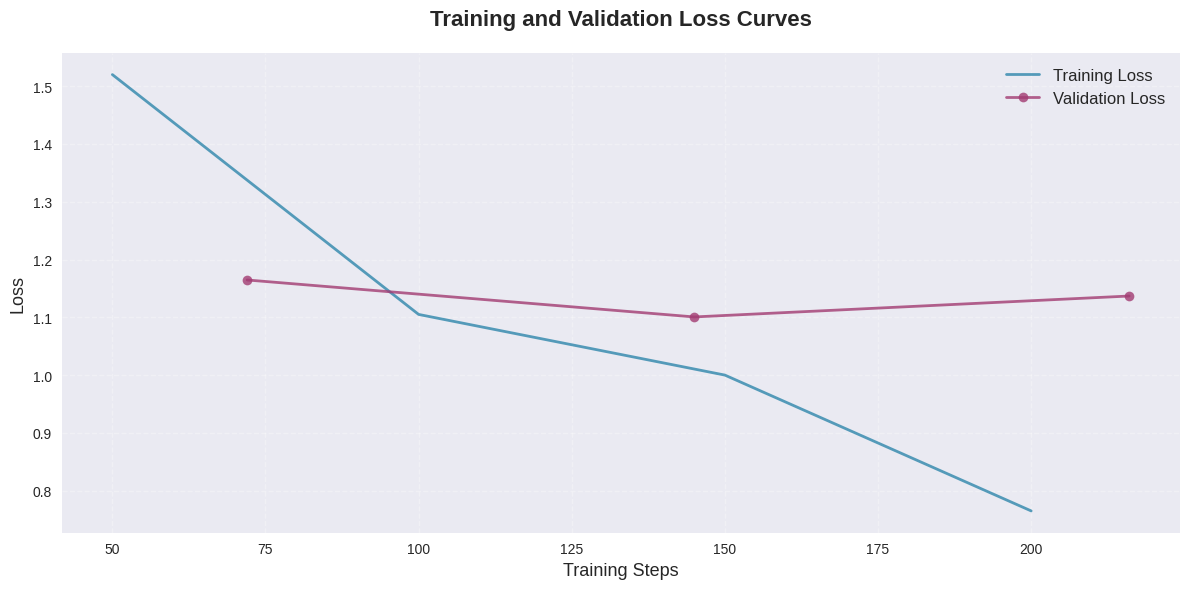

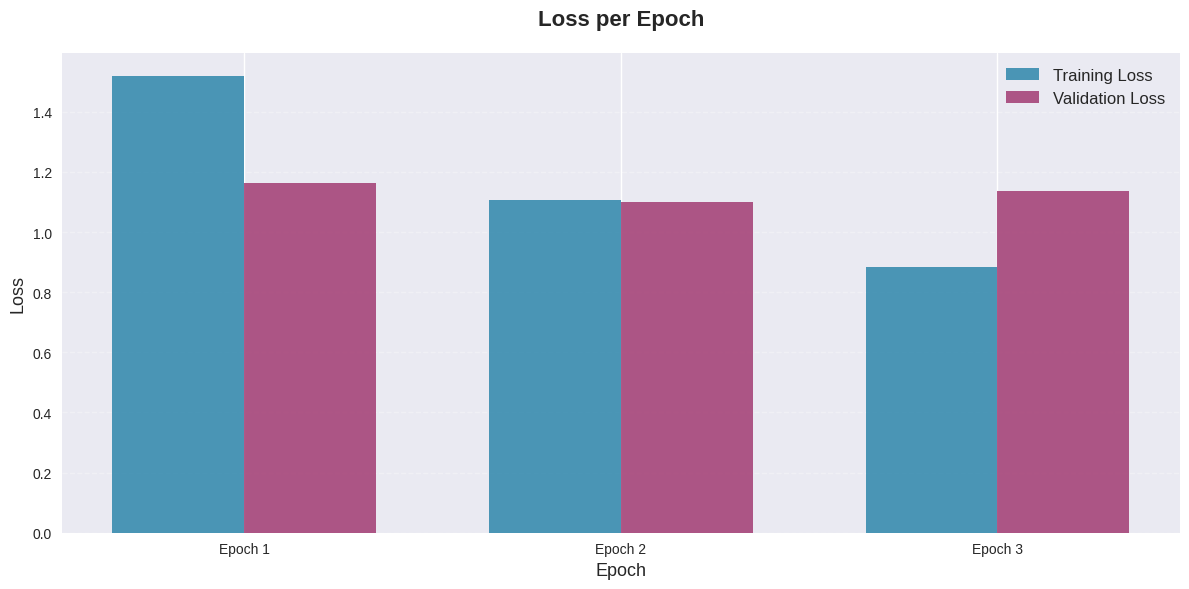


Training Statistics:
  Initial training loss: 1.5200
  Final training loss: 0.7650
  Training loss reduction: 49.67%
  Initial validation loss: 1.1646
  Final validation loss: 1.1368
  Validation loss reduction: 2.38%
  Epoch 1: train=1.5200, val=1.1646
  Epoch 2: train=1.1050, val=1.1006
  Epoch 3: train=0.8825, val=1.1368


In [24]:
# Load training history from trainer state
from collections import defaultdict
try:
    if hasattr(trainer.state, 'log_history'):
        train_history = [
            {'step': log.get('step'), 'epoch': log.get('epoch'), 'loss': log['loss']}
            for log in trainer.state.log_history
            if 'loss' in log and 'eval_loss' not in log
        ]
        eval_history = [
            {'step': log.get('step'), 'epoch': log.get('epoch'), 'loss': log['eval_loss']}
            for log in trainer.state.log_history
            if 'eval_loss' in log
        ]

        if train_history and eval_history:
            target_epochs = int(training_args.num_train_epochs)
            if len(eval_history) > target_epochs:
                eval_history = eval_history[-target_epochs:]
            train_losses = [record['loss'] for record in train_history]
            eval_losses = [record['loss'] for record in eval_history]
            train_steps = [record['step'] for record in train_history]
            eval_steps = [record['step'] for record in eval_history]

            fig, ax = plt.subplots(1, 1, figsize=(12, 6))
            ax.plot(train_steps, train_losses, label='Training Loss', linewidth=2, alpha=0.8, color='#2E86AB')
            ax.plot(eval_steps, eval_losses, label='Validation Loss', linewidth=2, alpha=0.8, marker='o', color='#A23B72')
            ax.set_title('Training and Validation Loss Curves', fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel('Training Steps', fontsize=13)
            ax.set_ylabel('Loss', fontsize=13)
            ax.legend(fontsize=12, loc='upper right')
            ax.grid(True, alpha=0.3, linestyle='--')
            plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
            plt.show()

            # Aggregate losses per epoch for easier comparison
            epoch_train_losses = defaultdict(list)
            epoch_eval_losses = {}

            for record in train_history:
                epoch_value = record.get('epoch')
                if epoch_value is None:
                    continue
                epoch_idx = max(1, int(np.ceil(epoch_value)))
                epoch_train_losses[epoch_idx].append(record['loss'])

            for record in eval_history:
                epoch_value = record.get('epoch')
                if epoch_value is None:
                    continue
                epoch_idx = max(1, int(round(epoch_value)))
                epoch_eval_losses[epoch_idx] = record['loss']

            epochs = list(range(1, int(training_args.num_train_epochs) + 1))
            train_epoch_values = []
            eval_epoch_values = []

            for epoch in epochs:
                epoch_train = epoch_train_losses.get(epoch)
                train_epoch_values.append(float(np.mean(epoch_train)) if epoch_train else np.nan)
                eval_epoch_values.append(epoch_eval_losses.get(epoch, np.nan))

            x = np.arange(len(epochs))
            width = 0.35
            fig, ax = plt.subplots(1, 1, figsize=(12, 6))
            ax.bar(x - width / 2, train_epoch_values, width, label='Training Loss', color='#2E86AB', alpha=0.85)
            ax.bar(x + width / 2, eval_epoch_values, width, label='Validation Loss', color='#A23B72', alpha=0.85)
            ax.set_title('Loss per Epoch', fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel('Epoch', fontsize=13)
            ax.set_ylabel('Loss', fontsize=13)
            ax.set_xticks(x)
            ax.set_xticklabels([f'Epoch {epoch}' for epoch in epochs])
            ax.legend(fontsize=12, loc='upper right')
            ax.grid(True, axis='y', alpha=0.3, linestyle='--')
            plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR, 'training_history_per_epoch.png'), dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\nTraining Statistics:")
            print(f"  Initial training loss: {train_losses[0]:.4f}")
            print(f"  Final training loss: {train_losses[-1]:.4f}")
            print(f"  Training loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")
            if eval_losses:
                print(f"  Initial validation loss: {eval_losses[0]:.4f}")
                print(f"  Final validation loss: {eval_losses[-1]:.4f}")
                print(f"  Validation loss reduction: {((eval_losses[0] - eval_losses[-1]) / eval_losses[0] * 100):.2f}%")

            for idx, epoch in enumerate(epochs):
                train_epoch = train_epoch_values[idx]
                eval_epoch = eval_epoch_values[idx]
                train_display = f"{train_epoch:.4f}" if not np.isnan(train_epoch) else "n/a"
                eval_display = f"{eval_epoch:.4f}" if not np.isnan(eval_epoch) else "n/a"
                print(f"  Epoch {epoch}: train={train_display}, val={eval_display}")
        else:
            print("Insufficient loss data for plotting.")
    else:
        print("Training state not available.")
except Exception as e:
    print(f"Error plotting losses: {e}")


## 8. Model Evaluation on Test Set


In [ ]:
# Evaluation function
def evaluate_model(model, tokenizer, test_df, num_samples=10, max_new_tokens=512):
    """
    Evaluate model on test set samples.
    """
    model.eval()
    results = []
    
    # Sample from test set
    test_samples = test_df.sample(min(num_samples, len(test_df)), random_state=42)
    
    for idx, row in test_samples.iterrows():
        instruction = row['instruction']
        expected = row['target']
        label = row['label']
        
        # Create prompt
        prompt = f"[INST] {instruction} [/INST]\n\n"
        
        # Tokenize
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        
        # Generate with improved parameters to prevent incomplete outputs
        with torch.no_grad():
            # Determine max_new_tokens based on label (SENSITIVE tends to be longer)
            label_max_tokens = max_new_tokens * 1.5 if label == 'SENSITIVE' else max_new_tokens
            
            outputs = model.generate(
                **inputs.to(model.device),
                max_new_tokens=int(label_max_tokens),
                min_new_tokens=50,  # Ensure minimum length
                temperature=0.7,
                top_p=0.9,
                top_k=50,  # Add top_k for better diversity
                do_sample=True,
                repetition_penalty=1.2,  # Prevent repetition
                length_penalty=1.1,  # Encourage longer completions
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=3  # Prevent 3-gram repetition
            )
        
        # Decode
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the generated part (after [/INST])
        if "[/INST]" in generated:
            generated = generated.split("[/INST]")[-1].strip()
        
        results.append({
            'label': label,
            'title': row['title'],
            'article': row['article_500'],  # Full article, no truncation
            'expected': expected,  # Full expected rewrite, no truncation
            'generated': generated  # Full generated rewrite, no truncation
        })
    
    return results

# Run evaluation
print("Evaluating model on test set...")
eval_results = evaluate_model(model, tokenizer, test_df, num_samples=10)

print(f"\nEvaluated {len(eval_results)} samples.")

# Save evaluation results to CSV
eval_results_df = pd.DataFrame(eval_results)
eval_results_path = os.path.join(RESULTS_DIR, 'evaluation_results.csv')
eval_results_df.to_csv(eval_results_path, index=False)
print(f"✓ Evaluation results saved to: {eval_results_path}")


Evaluating model on test set...

Evaluated 10 samples.
✓ Evaluation results saved to: /blue/eee6778/koshyreshma/AI/MiniNewsAI/results/kid_safe_rewriter/evaluation_results.csv


## 8.1. Install Additional Evaluation Libraries


In [36]:
# Install required packages for enhanced evaluation metrics
# Uncomment if needed:
# %pip install -q bert-score textstat nltk rouge-score
# import nltk
# nltk.download('punkt', quiet=True)
# nltk.download('averaged_perceptron_tagger', quiet=True)

# Import evaluation libraries
try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
except ImportError:
    ROUGE_AVAILABLE = False
    print("⚠️  rouge-score not available. Install with: pip install rouge-score")

try:
    from bert_score import score as bert_score_fn
    BERTSCORE_AVAILABLE = True
except ImportError:
    BERTSCORE_AVAILABLE = False
    print("⚠️  bert-score not available. Install with: pip install bert-score")

try:
    import textstat
    TEXTSTAT_AVAILABLE = True
except ImportError:
    TEXTSTAT_AVAILABLE = False
    print("⚠️  textstat not available. Install with: pip install textstat")

try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from nltk.tokenize import word_tokenize
    import nltk
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger', quiet=True)
    BLEU_AVAILABLE = True
except ImportError:
    BLEU_AVAILABLE = False
    print("⚠️  nltk not available. Install with: pip install nltk")

print("Evaluation libraries check:")
print(f"  ROUGE: {'✓' if ROUGE_AVAILABLE else '✗'}")
print(f"  BERTScore: {'✓' if BERTSCORE_AVAILABLE else '✗'}")
print(f"  Readability (textstat): {'✓' if TEXTSTAT_AVAILABLE else '✗'}")
print(f"  BLEU (nltk): {'✓' if BLEU_AVAILABLE else '✗'}")


Evaluation libraries check:
  ROUGE: ✓
  BERTScore: ✓
  Readability (textstat): ✓
  BLEU (nltk): ✓


In [37]:
# Display evaluation results
for i, result in enumerate(eval_results[5:], 1):  # Show first 5
    print("=" * 80)
    print(f"Sample {i} - Label: {result['label']}")
    print("=" * 80)
    print(f"\nTitle: {result['title']}")
    print(f"\nOriginal Article (excerpt):\n{result['article']}")
    print(f"\nExpected Rewrite (excerpt):\n{result['expected']}")
    print(f"\nGenerated Rewrite (excerpt):\n{result['generated']}")
    print("\n" + "-" * 80 + "\n")


Sample 1 - Label: SAFE

Title: AICTE nod must to offer BBA, BCA from 2024-25

Original Article (excerpt):
All arts and science colleges will have to get approval from the All-India Council for Technical Education (AICTE) So far, colleges got approval from affiliated universities for BBA, BCA and from the ...

Expected Rewrite (excerpt):
Title: AICTE nod must to offer BBA, BCA from 2024-25

From now on, if you want to study BBA or BCA, you need to get permission from a special group called the All-India Council for Technical Education (AICTE). This group will make sure that the colleges teaching these subjects are good enough.

Before this, colleges only needed to get permission from the universities where they were attached to. But now, they also need to get permission from the AICTE. This means that colleges teaching BCom and BA won't need to get permission from the AICTE.

The AICTE will also make new rules for these subjects and will make sure that colleges have enough teachers and 

In [38]:
# Enhanced evaluation metrics function
def compute_enhanced_metrics(expected, generated, label='SAFE'):
    """
    Compute comprehensive evaluation metrics including:
    - Lexical similarity: BLEU, ROUGE-L, Jaccard
    - Semantic similarity: BERTScore
    - Readability: Flesch-Kincaid, Gunning Fog
    - Length preservation
    """
    metrics = {}
    
    # 1. Jaccard similarity (word overlap)
    expected_words = set(expected.lower().split())
    generated_words = set(generated.lower().split())
    intersection = expected_words & generated_words
    union = expected_words | generated_words
    jaccard = len(intersection) / len(union) if union else 0
    metrics['jaccard_similarity'] = jaccard
    
    # 2. Length ratio
    len_ratio = len(generated.split()) / len(expected.split()) if expected.split() else 0
    metrics['length_ratio'] = len_ratio
    
    # 3. BLEU score (lexical similarity)
    if BLEU_AVAILABLE:
        try:
            expected_tokens = word_tokenize(expected.lower())
            generated_tokens = word_tokenize(generated.lower())
            smoothing = SmoothingFunction().method1
            bleu_score = sentence_bleu([expected_tokens], generated_tokens, smoothing_function=smoothing)
            metrics['bleu'] = bleu_score
        except Exception as e:
            metrics['bleu'] = None
    else:
        metrics['bleu'] = None
    
    # 4. ROUGE-L score (lexical similarity with longest common subsequence)
    if ROUGE_AVAILABLE:
        try:
            rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            rouge_scores = rouge.score(expected, generated)
            metrics['rouge_l'] = rouge_scores['rougeL'].fmeasure
        except Exception as e:
            metrics['rouge_l'] = None
    else:
        metrics['rouge_l'] = None
    
    # 5. BERTScore (semantic similarity)
    # Note: BERTScore computation is expensive, so we'll compute it in batch later
    metrics['bertscore'] = None  # Will compute separately in batch
    
    # 6. Readability metrics (for age-appropriateness)
    if TEXTSTAT_AVAILABLE:
        try:
            # Flesch-Kincaid Grade Level (lower = easier to read)
            fk_grade = textstat.flesch_kincaid_grade(generated)
            metrics['flesch_kincaid_grade'] = fk_grade
            
            # Gunning Fog Index (lower = easier to read)
            fog_index = textstat.gunning_fog(generated)
            metrics['gunning_fog_index'] = fog_index
            
            # Flesch Reading Ease (higher = easier to read, 0-100)
            flesch_ease = textstat.flesch_reading_ease(generated)
            metrics['flesch_reading_ease'] = flesch_ease
            
            # Age-appropriateness: Target 6-14 years old
            # Flesch-Kincaid Grade Level should be roughly 6-14
            # Note: Lower scores are better for younger readers
            metrics['age_appropriate'] = (fk_grade >= 4 and fk_grade <= 14)
        except Exception as e:
            metrics['flesch_kincaid_grade'] = None
            metrics['gunning_fog_index'] = None
            metrics['flesch_reading_ease'] = None
            metrics['age_appropriate'] = None
    else:
        metrics['flesch_kincaid_grade'] = None
        metrics['gunning_fog_index'] = None
        metrics['flesch_reading_ease'] = None
        metrics['age_appropriate'] = None
    
    return metrics

# Wrapper for backward compatibility
def compute_simple_metrics(expected, generated):
    """Backward compatibility wrapper - calls enhanced metrics"""
    enhanced = compute_enhanced_metrics(expected, generated)
    return {
        'jaccard_similarity': enhanced['jaccard_similarity'],
        'length_ratio': enhanced['length_ratio']
    }

# Compute enhanced metrics for all results
print("Computing enhanced evaluation metrics...")
print("=" * 80)

metrics_list = []
for i, result in enumerate(eval_results):
    metrics = compute_enhanced_metrics(result['expected'], result['generated'], result['label'])
    metrics['label'] = result['label']
    metrics_list.append(metrics)
    
    # Progress indicator
    if (i + 1) % 5 == 0:
        print(f"  Processed {i + 1}/{len(eval_results)} samples...")

# Compute BERTScore in batch (more efficient)
if BERTSCORE_AVAILABLE:
    print("\nComputing BERTScore (semantic similarity) in batch...")
    try:
        expected_texts = [r['expected'] for r in eval_results]
        generated_texts = [r['generated'] for r in eval_results]
        
        # BERTScore returns P, R, F1 scores
        P, R, F1 = bert_score_fn(generated_texts, expected_texts, lang='en', verbose=False)
        
        # Add BERTScore to metrics
        for i, metrics in enumerate(metrics_list):
            metrics['bertscore_precision'] = float(P[i].cpu().item())
            metrics['bertscore_recall'] = float(R[i].cpu().item())
            metrics['bertscore_f1'] = float(F1[i].cpu().item())
            metrics['bertscore'] = float(F1[i].cpu().item())  # Use F1 as main BERTScore metric
        print("  ✓ BERTScore computation complete")
    except Exception as e:
        print(f"  ⚠️  BERTScore computation failed: {e}")
        for metrics in metrics_list:
            metrics['bertscore'] = None
            metrics['bertscore_precision'] = None
            metrics['bertscore_recall'] = None
            metrics['bertscore_f1'] = None
else:
    for metrics in metrics_list:
        metrics['bertscore'] = None
        metrics['bertscore_precision'] = None
        metrics['bertscore_recall'] = None
        metrics['bertscore_f1'] = None

metrics_df = pd.DataFrame(metrics_list)

print("\n" + "=" * 80)
print("COMPREHENSIVE EVALUATION METRICS")
print("=" * 80)

print(f"\n{'Metric':<30} {'Overall':<15} {'SAFE':<15} {'SENSITIVE':<15}")
print("-" * 75)

# Lexical Similarity Metrics
if metrics_df['jaccard_similarity'].notna().any():
    print(f"\n📊 LEXICAL SIMILARITY:")
    print(f"{'  Jaccard Similarity':<30} {metrics_df['jaccard_similarity'].mean():.4f}         {metrics_df[metrics_df['label']=='SAFE']['jaccard_similarity'].mean():.4f}         {metrics_df[metrics_df['label']=='SENSITIVE']['jaccard_similarity'].mean():.4f}")
    
if metrics_df['bleu'].notna().any():
    print(f"{'  BLEU Score':<30} {metrics_df['bleu'].mean():.4f}         {metrics_df[metrics_df['label']=='SAFE']['bleu'].mean():.4f}         {metrics_df[metrics_df['label']=='SENSITIVE']['bleu'].mean():.4f}")
    
if metrics_df['rouge_l'].notna().any():
    print(f"{'  ROUGE-L F1':<30} {metrics_df['rouge_l'].mean():.4f}         {metrics_df[metrics_df['label']=='SAFE']['rouge_l'].mean():.4f}         {metrics_df[metrics_df['label']=='SENSITIVE']['rouge_l'].mean():.4f}")

# Semantic Similarity
if metrics_df['bertscore'].notna().any():
    print(f"\n🧠 SEMANTIC SIMILARITY:")
    print(f"{'  BERTScore F1':<30} {metrics_df['bertscore'].mean():.4f}         {metrics_df[metrics_df['label']=='SAFE']['bertscore'].mean():.4f}         {metrics_df[metrics_df['label']=='SENSITIVE']['bertscore'].mean():.4f}")
    print(f"{'  BERTScore Precision':<30} {metrics_df['bertscore_precision'].mean():.4f}         {metrics_df[metrics_df['label']=='SAFE']['bertscore_precision'].mean():.4f}         {metrics_df[metrics_df['label']=='SENSITIVE']['bertscore_precision'].mean():.4f}")
    print(f"{'  BERTScore Recall':<30} {metrics_df['bertscore_recall'].mean():.4f}         {metrics_df[metrics_df['label']=='SAFE']['bertscore_recall'].mean():.4f}         {metrics_df[metrics_df['label']=='SENSITIVE']['bertscore_recall'].mean():.4f}")

# Readability Metrics
if metrics_df['flesch_kincaid_grade'].notna().any():
    print(f"\n📚 READABILITY (Age-Appropriateness):")
    print(f"{'  Flesch-Kincaid Grade':<30} {metrics_df['flesch_kincaid_grade'].mean():.2f}         {metrics_df[metrics_df['label']=='SAFE']['flesch_kincaid_grade'].mean():.2f}         {metrics_df[metrics_df['label']=='SENSITIVE']['flesch_kincaid_grade'].mean():.2f}")
    print(f"{'  Gunning Fog Index':<30} {metrics_df['gunning_fog_index'].mean():.2f}         {metrics_df[metrics_df['label']=='SAFE']['gunning_fog_index'].mean():.2f}         {metrics_df[metrics_df['label']=='SENSITIVE']['gunning_fog_index'].mean():.2f}")
    print(f"{'  Flesch Reading Ease':<30} {metrics_df['flesch_reading_ease'].mean():.2f}         {metrics_df[metrics_df['label']=='SAFE']['flesch_reading_ease'].mean():.2f}         {metrics_df[metrics_df['label']=='SENSITIVE']['flesch_reading_ease'].mean():.2f}")
    
    # Age-appropriateness check
    age_appropriate_pct = metrics_df['age_appropriate'].sum() / len(metrics_df) * 100
    print(f"{'  Age-Appropriate (4-14)':<30} {age_appropriate_pct:.1f}%         {(metrics_df[metrics_df['label']=='SAFE']['age_appropriate'].sum() / len(metrics_df[metrics_df['label']=='SAFE']) * 100):.1f}%         {(metrics_df[metrics_df['label']=='SENSITIVE']['age_appropriate'].sum() / len(metrics_df[metrics_df['label']=='SENSITIVE']) * 100):.1f}%")

# Length Preservation
print(f"\n📏 LENGTH PRESERVATION:")
print(f"{'  Length Ratio':<30} {metrics_df['length_ratio'].mean():.4f}         {metrics_df[metrics_df['label']=='SAFE']['length_ratio'].mean():.4f}         {metrics_df[metrics_df['label']=='SENSITIVE']['length_ratio'].mean():.4f}")

print("\n" + "=" * 80)
print("Target Age Range: 6-14 years old")
print("Ideal Flesch-Kincaid Grade: 6-14")
print("Ideal Flesch Reading Ease: 60-80 (Plain English)")
print("=" * 80)

# Save evaluation metrics to CSV
eval_metrics_path = os.path.join(RESULTS_DIR, 'evaluation_metrics.csv')
metrics_df.to_csv(eval_metrics_path, index=False)
print(f"\n✓ Evaluation metrics saved to: {eval_metrics_path}")


Computing enhanced evaluation metrics...
  Processed 5/10 samples...
  Processed 10/10 samples...

Computing BERTScore (semantic similarity) in batch...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ BERTScore computation complete

COMPREHENSIVE EVALUATION METRICS

Metric                         Overall         SAFE            SENSITIVE      
---------------------------------------------------------------------------

📊 LEXICAL SIMILARITY:
  Jaccard Similarity           0.4426         0.3935         0.5162
  ROUGE-L F1                   0.5095         0.4610         0.5823

🧠 SEMANTIC SIMILARITY:
  BERTScore F1                 0.9256         0.9172         0.9382
  BERTScore Precision          0.9282         0.9182         0.9431
  BERTScore Recall             0.9239         0.9168         0.9345

📚 READABILITY (Age-Appropriateness):
  Flesch-Kincaid Grade         9.17         8.83         9.68
  Gunning Fog Index            10.15         10.04         10.31
  Flesch Reading Ease          61.52         65.98         54.83
  Age-Appropriate (4-14)       100.0%         100.0%         100.0%

📏 LENGTH PRESERVATION:
  Length Ratio                 1.0757         1.0619         1.096

In [ ]:
# Redefine create_comparison_visualization with fixed text wrapping to prevent overlap
from textwrap import wrap

def create_comparison_visualization_fixed(eval_results, label_type, num_examples=2):
    """
    Create visualization comparing original, expected, and generated rewrites.
    Fixed version with proper text wrapping to avoid overlapping.
    """
    label_results = [r for r in eval_results if r['label'] == label_type][:num_examples]
    
    if not label_results:
        print(f"No {label_type} examples found.")
        return
    
    for idx, result in enumerate(label_results, 1):
        # Calculate dynamic figure height based on text length
        total_chars = len(result['article']) + len(result['expected']) + len(result['generated'])
        fig_height = max(20, min(35, total_chars / 80))
        
        fig = plt.figure(figsize=(16, fig_height))
        fig.suptitle(f'{label_type} Example {idx}: {result["title"]}', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        def wrap_text_properly(text, width=85):
            """Wrap text properly"""
            wrapped_lines = []
            for paragraph in text.split('\n'):
                if paragraph.strip():
                    wrapped = wrap(paragraph, width=width, break_long_words=False, break_on_hyphens=False)
                    wrapped_lines.extend(wrapped)
                else:
                    wrapped_lines.append('')
            return '\n'.join(wrapped_lines)
        
        # Original article (TOP PANEL - verified correct mapping)
        ax1 = fig.add_subplot(3, 1, 1)
        wrapped_article = wrap_text_properly(result['article'], width=85)  # result['article'] = original input
        ax1.text(0.02, 0.98, f"ORIGINAL ARTICLE:\n\n{wrapped_article}", 
                transform=ax1.transAxes, fontsize=8, verticalalignment='top',
                family='monospace', wrap=True,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7, pad=0.5))
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.axis('off')
        ax1.set_title('Original Article', fontweight='bold', fontsize=12, pad=10)
        
        # Expected rewrite (MIDDLE PANEL - verified correct mapping)
        ax2 = fig.add_subplot(3, 1, 2)
        wrapped_expected = wrap_text_properly(result['expected'], width=85)  # result['expected'] = target rewrite
        ax2.text(0.02, 0.98, f"EXPECTED REWRITE:\n\n{wrapped_expected}", 
                transform=ax2.transAxes, fontsize=8, verticalalignment='top',
                family='monospace', wrap=True,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7, pad=0.5))
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title('Expected Rewrite', fontweight='bold', fontsize=12, pad=10)
        
        # Generated rewrite (BOTTOM PANEL - verified correct mapping)
        ax3 = fig.add_subplot(3, 1, 3)
        wrapped_generated = wrap_text_properly(result['generated'], width=85)  # result['generated'] = model output
        ax3.text(0.02, 0.98, f"GENERATED REWRITE:\n\n{wrapped_generated}", 
                transform=ax3.transAxes, fontsize=8, verticalalignment='top',
                family='monospace', wrap=True,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7, pad=0.5))
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)
        ax3.axis('off')
        ax3.set_title('Generated Rewrite', fontweight='bold', fontsize=12, pad=10)
        
        # Completion ratio
        expected_len = len(result['expected'].split())
        generated_len = len(result['generated'].split())
        completion_ratio = generated_len / expected_len if expected_len > 0 else 0
        
        fig.text(0.5, 0.01, 
                f'Length: Expected={expected_len} words, Generated={generated_len} words, Ratio={completion_ratio:.1%}',
                ha='center', fontsize=10, style='italic',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.98], h_pad=3.0)
        save_path = os.path.join(RESULTS_DIR, f'comparison_{label_type.lower()}_example_{idx}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        # Save as text file
        text_save_path = os.path.join(RESULTS_DIR, f'comparison_{label_type.lower()}_example_{idx}.txt')
        with open(text_save_path, 'w', encoding='utf-8') as f:
            f.write(f"{label_type} Example {idx}: {result['title']}\n")
            f.write("=" * 100 + "\n\n")
            f.write("ORIGINAL ARTICLE:\n" + "-" * 100 + "\n")
            f.write(result['article'] + "\n\n")
            f.write("EXPECTED REWRITE:\n" + "-" * 100 + "\n")
            f.write(result['expected'] + "\n\n")
            f.write("GENERATED REWRITE:\n" + "-" * 100 + "\n")
            f.write(result['generated'] + "\n\n")
            f.write(f"Length: Expected={expected_len} words, Generated={generated_len} words, Ratio={completion_ratio:.1%}\n")

# Replace the old function with the fixed version
create_comparison_visualization = create_comparison_visualization_fixed
print("✓ Fixed visualization function loaded (prevents text overlapping)")
print("✓ Verified mapping: TOP=Original Article, MIDDLE=Expected Rewrite, BOTTOM=Generated Rewrite")


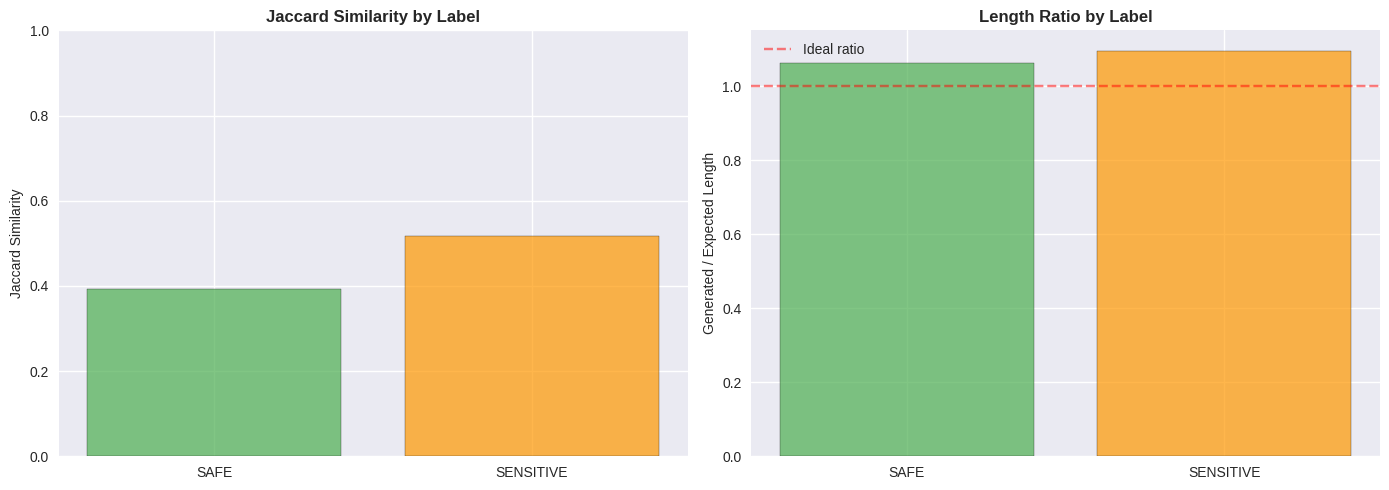


✓ Evaluation metrics plot saved to: /blue/eee6778/koshyreshma/AI/MiniNewsAI/results/kid_safe_rewriter/evaluation_metrics.png


In [29]:
# Visualize metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jaccard similarity by label
safe_jaccard = metrics_df[metrics_df['label'] == 'SAFE']['jaccard_similarity']
sensitive_jaccard = metrics_df[metrics_df['label'] == 'SENSITIVE']['jaccard_similarity']

axes[0].bar(['SAFE', 'SENSITIVE'], 
            [safe_jaccard.mean() if len(safe_jaccard) > 0 else 0, 
             sensitive_jaccard.mean() if len(sensitive_jaccard) > 0 else 0],
            color=['#4CAF50', '#FF9800'], alpha=0.7, edgecolor='black')
axes[0].set_title('Jaccard Similarity by Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jaccard Similarity', fontsize=10)
axes[0].set_ylim([0, 1])

# Length ratio by label
safe_ratio = metrics_df[metrics_df['label'] == 'SAFE']['length_ratio']
sensitive_ratio = metrics_df[metrics_df['label'] == 'SENSITIVE']['length_ratio']

axes[1].bar(['SAFE', 'SENSITIVE'], 
            [safe_ratio.mean() if len(safe_ratio) > 0 else 0, 
             sensitive_ratio.mean() if len(sensitive_ratio) > 0 else 0],
            color=['#4CAF50', '#FF9800'], alpha=0.7, edgecolor='black')
axes[1].set_title('Length Ratio by Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Generated / Expected Length', fontsize=10)
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Ideal ratio')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'evaluation_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Evaluation metrics plot saved to: {os.path.join(RESULTS_DIR, 'evaluation_metrics.png')}")


## 9. Before/After Comparison Visualization


Creating before/after comparisons...


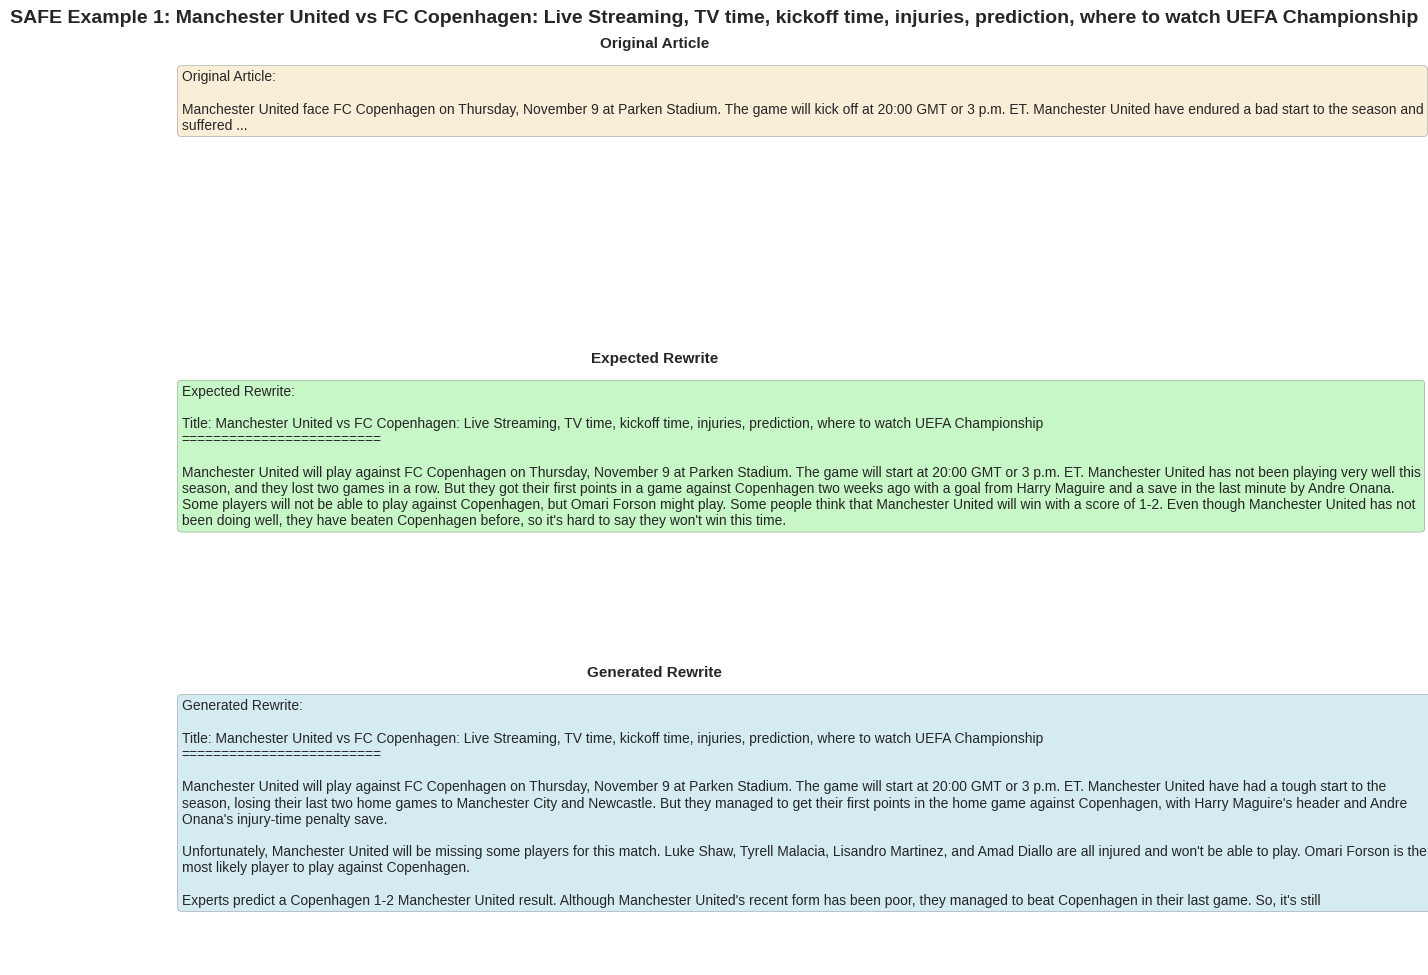

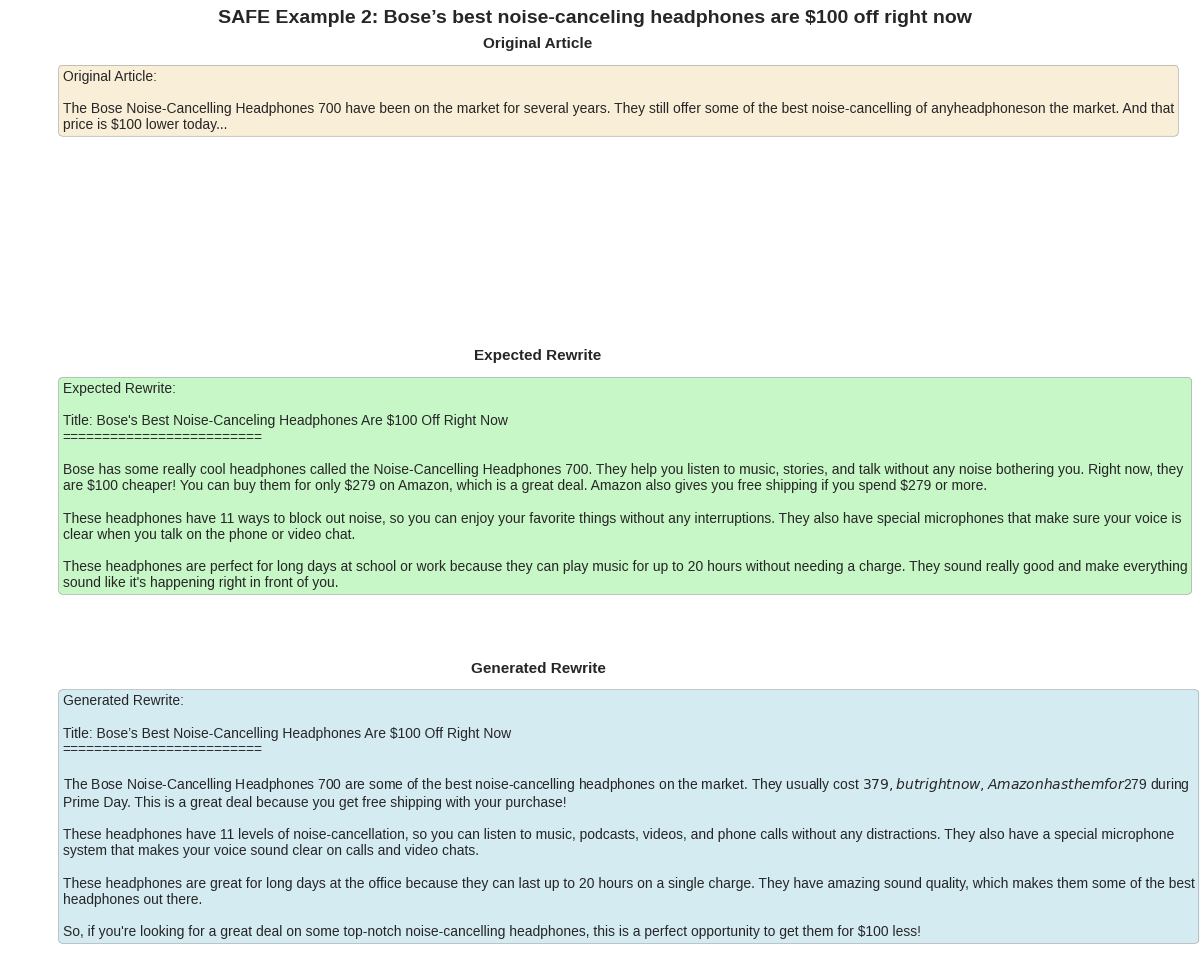

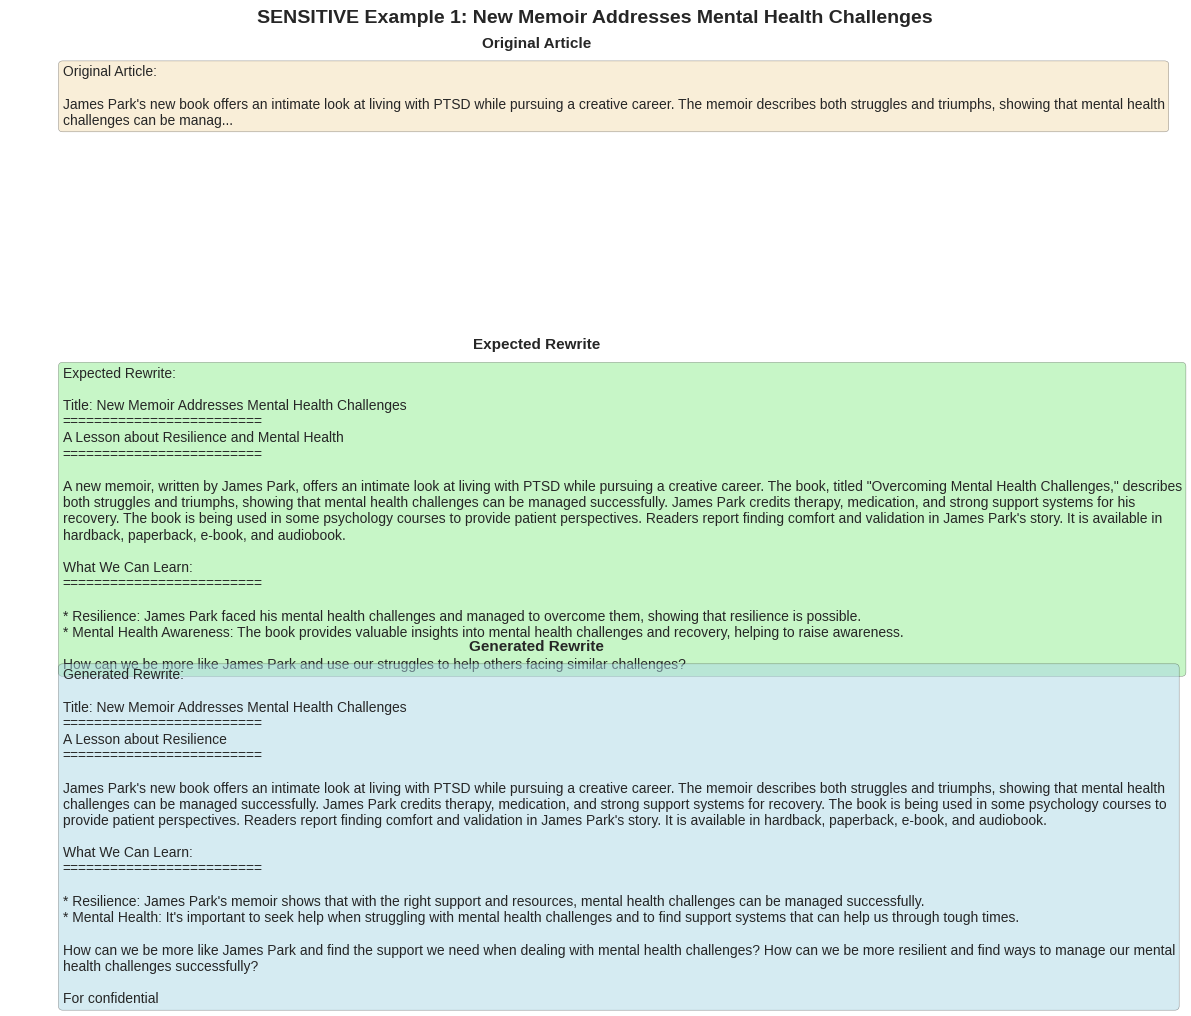

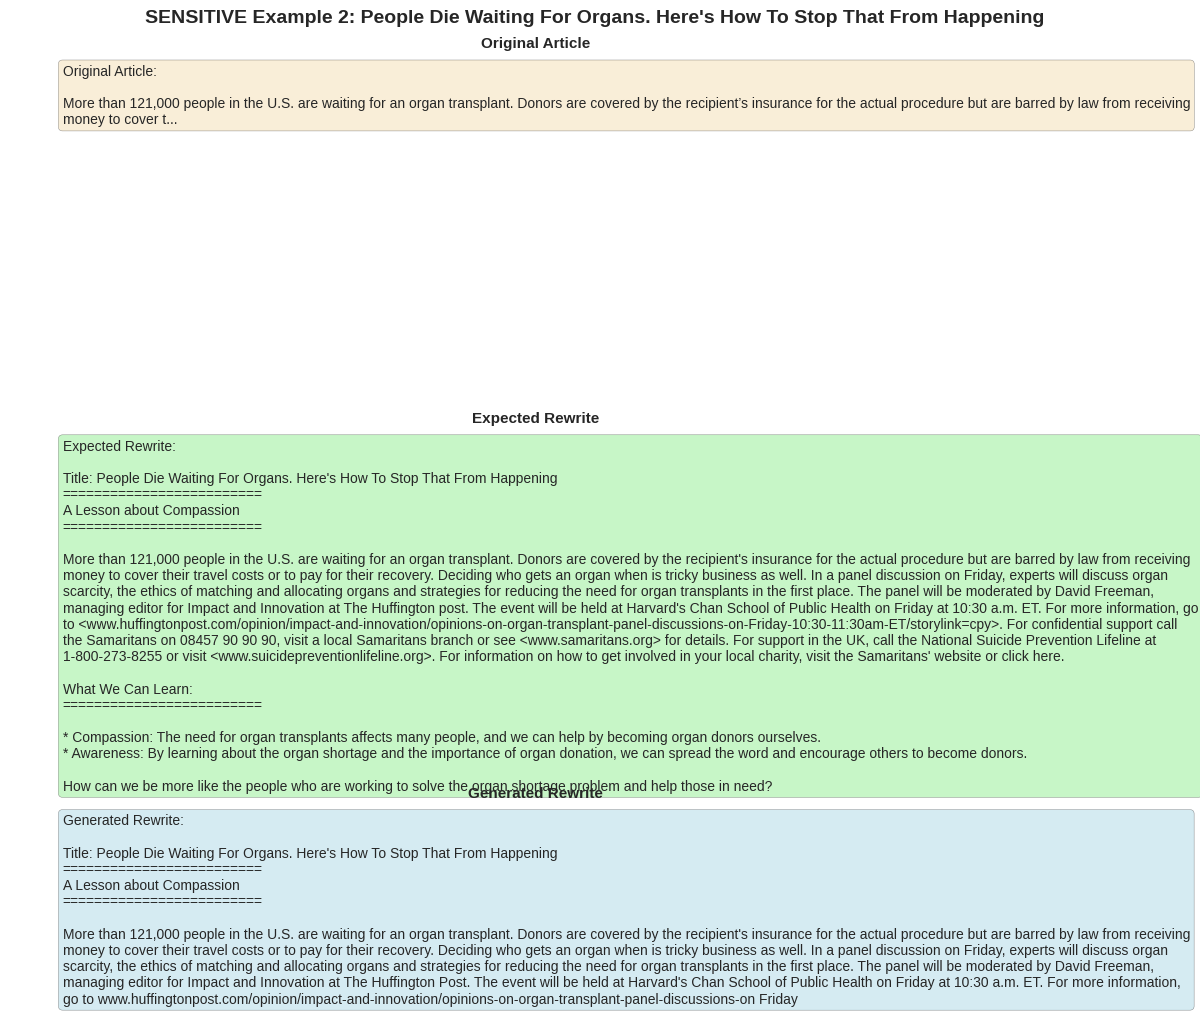


✓ Comparison visualizations saved to: /blue/eee6778/koshyreshma/AI/MiniNewsAI/results/kid_safe_rewriter


In [30]:
# Create before/after comparison for SAFE and SENSITIVE examples
def create_comparison_visualization(eval_results, label_type, num_examples=2):
    """
    Create visualization comparing original, expected, and generated rewrites.
    """
    label_results = [r for r in eval_results if r['label'] == label_type][:num_examples]
    
    if not label_results:
        print(f"No {label_type} examples found.")
        return
    
    for idx, result in enumerate(label_results, 1):
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
        fig.suptitle(f'{label_type} Example {idx}: {result["title"]}', fontsize=14, fontweight='bold')
        
        # Original article
        axes[0].text(0.05, 0.95, f"Original Article:\n\n{result['article']}", 
                    transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), wrap=True)
        axes[0].set_xlim(0, 1)
        axes[0].set_ylim(0, 1)
        axes[0].axis('off')
        axes[0].set_title('Original Article', fontweight='bold', fontsize=11)
        
        # Expected rewrite
        axes[1].text(0.05, 0.95, f"Expected Rewrite:\n\n{result['expected']}", 
                    transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5), wrap=True)
        axes[1].set_xlim(0, 1)
        axes[1].set_ylim(0, 1)
        axes[1].axis('off')
        axes[1].set_title('Expected Rewrite', fontweight='bold', fontsize=11)
        
        # Generated rewrite
        axes[2].text(0.05, 0.95, f"Generated Rewrite:\n\n{result['generated']}", 
                    transform=axes[2].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5), wrap=True)
        axes[2].set_xlim(0, 1)
        axes[2].set_ylim(0, 1)
        axes[2].axis('off')
        axes[2].set_title('Generated Rewrite', fontweight='bold', fontsize=11)
        
        plt.tight_layout()
        save_path = os.path.join(RESULTS_DIR, f'comparison_{label_type.lower()}_example_{idx}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# Create visualizations
print("Creating before/after comparisons...")
create_comparison_visualization(eval_results, 'SAFE', num_examples=2)
create_comparison_visualization(eval_results, 'SENSITIVE', num_examples=2)
print(f"\n✓ Comparison visualizations saved to: {RESULTS_DIR}")


## 11. Inference Section - Example Rewrites


In [31]:
# Inference function for easy use
def generate_kid_safe_rewrite(model, tokenizer, article, title, label='SAFE', max_new_tokens=256):
    """
    Generate kid-safe rewrite for a given article.
    
    Args:
        model: Fine-tuned model
        tokenizer: Tokenizer
        article: Original article text
        title: Article title
        label: SAFE or SENSITIVE
        max_new_tokens: Maximum tokens to generate
    
    Returns:
        Generated rewrite text
    """
    instruction = create_instruction_prompt(label, article, title)
    prompt = f"[INST] {instruction} [/INST]\n\n"
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs.to(model.device),
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    if "[/INST]" in generated:
        generated = generated.split("[/INST]")[-1].strip()
    
    return generated

print("Inference function created.")


Inference function created.


In [32]:
# Example 1: SAFE rewrite
example_article_safe = """Scientists have discovered a new species of butterfly in the Amazon rainforest. 
The butterfly has bright blue wings with orange spots. Researchers spent three years studying 
the insect before confirming it was a new species. The discovery was published in a scientific journal."""

example_title_safe = "New Butterfly Species Found in Amazon"

print("=" * 80)
print("Example 1: SAFE Rewrite")
print("=" * 80)
print(f"\nOriginal Article:\n{example_article_safe}")
print(f"\n{'='*80}")
print("\nGenerated Rewrite:")
rewrite_safe = generate_kid_safe_rewrite(model, tokenizer, example_article_safe, example_title_safe, label='SAFE')
print(rewrite_safe)


Example 1: SAFE Rewrite

Original Article:
Scientists have discovered a new species of butterfly in the Amazon rainforest. 
The butterfly has bright blue wings with orange spots. Researchers spent three years studying 
the insect before confirming it was a new species. The discovery was published in a scientific journal.


Generated Rewrite:
Title: New Butterfly Species Found in Amazon

Scientists have found a new kind of butterfly in the Amazon rainforest! This butterfly has bright blue wings with orange spots. Researchers studied it for three years before deciding it was a new species. They wrote about their discovery in a special journal for scientists. This new butterfly is a very important find because it helps us learn more about the amazing creatures in our world.

Article: New Butterfly Species Found in Amazon

Scientists have discovered a new kind of butterfly in the Amazon rainforest! This butterfly has bright blue wings with orange spots. Researchers spent three years studyi

In [33]:
# Example 2: SENSITIVE rewrite
example_article_sensitive = """A major company announced layoffs affecting thousands of workers. 
The decision was made due to economic challenges and changing market conditions. Employees were 
notified last week and will receive severance packages. The company plans to restructure its operations."""

example_title_sensitive = "Company Announces Workforce Reduction"

print("=" * 80)
print("Example 2: SENSITIVE Rewrite")
print("=" * 80)
print(f"\nOriginal Article:\n{example_article_sensitive}")
print(f"\n{'='*80}")
print("\nGenerated Rewrite:")
rewrite_sensitive = generate_kid_safe_rewrite(model, tokenizer, example_article_sensitive, example_title_sensitive, label='SENSITIVE')
print(rewrite_sensitive)


Example 2: SENSITIVE Rewrite

Original Article:
A major company announced layoffs affecting thousands of workers. 
The decision was made due to economic challenges and changing market conditions. Employees were 
notified last week and will receive severance packages. The company plans to restructure its operations.


Generated Rewrite:
Title: Company Announces Workforce Reduction
A Lesson about Adaptability

A major company has announced layoffs affecting thousands of workers. The decision was made due to economic challenges and changing market conditions. Employees were notified last week and will receive severance packages. The company plans to restructure its operations.

What We Can Learn:

* Adaptability: Companies must be able to adapt to changing market conditions and economic challenges.
* Communication: It's important for companies to communicate openly and honestly with their employees during difficult times.

How can we be more like the company and adapt to changes in our ow

In [34]:
# Example 3-5: More examples from test set
print("=" * 80)
print("Examples 3-5: Test Set Samples")
print("=" * 80)

additional_samples = test_df.sample(3, random_state=123)

for idx, (_, row) in enumerate(additional_samples.iterrows(), 3):
    print(f"\n{'='*80}")
    print(f"Example {idx}: {row['title']} (Label: {row['label']})")
    print(f"{'='*80}")
    print(f"\nOriginal Article (excerpt):\n{row['article_500'][:200]}...")
    print(f"\n{'='*80}")
    print("\nGenerated Rewrite:")
    rewrite = generate_kid_safe_rewrite(
        model, tokenizer, 
        row['article_500'], 
        row['title'], 
        label=row['label']
    )
    print(rewrite)
    print(f"\n{'='*80}")


Examples 3-5: Test Set Samples

Example 3: Illinois Tornado Wreaks Havoc Near Peoria (Label: SENSITIVE)

Original Article (excerpt):
NEW: Storm system has some similarities to "derecho" in June 2012, forecaster says. NEW: Chicago Bears halt their game against the Baltimore Ravens. Storm created tornadoes in Bone Gap and Miller City...


Generated Rewrite:
Title: Illinois Tornado Wreaks Havoc Near Peoria
A Lesson about Resilience

A tornado near Peoria, Illinois, caused significant damage to homes and buildings. The storm system had some similarities to the "derecho" in June 2012. The city of Washington, Illinois, was hit hard, with reports of homes being flattened and roofs being torn off. The Illinois National Guard sent a 10-person firefighting and search-and-rescue team to help with the recovery effort. The storm system was headed toward Chicago and threatened a large swath of the Midwest with dangerous winds, thunderstorms, and hail.

What We Can Learn:

* Resilience: Despite the d

## 12. Model Checkpointing & Final Notes


In [35]:
# Save final model and tokenizer to best_model subfolder for consistency
# Note: trainer already loaded the best model at the end due to load_best_model_at_end=True
model_base_dir = os.path.join(PROJECT_ROOT, "models", "kid_safe_rewriter")
best_model_dir = os.path.join(model_base_dir, "best_model")
os.makedirs(best_model_dir, exist_ok=True)

print(f"Saving final best model to {best_model_dir}...")
trainer.save_model(best_model_dir)
tokenizer.save_pretrained(best_model_dir)

# Extract and save best metrics similar to multiclass classifier
print("\nExtracting best metrics from training history...")
best_metrics = {}
if hasattr(trainer.state, 'log_history'):
    eval_history = [
        {'epoch': log.get('epoch'), 'eval_loss': log['eval_loss']}
        for log in trainer.state.log_history
        if 'eval_loss' in log
    ]
    if eval_history:
        # Find epoch with best (lowest) eval_loss
        best_eval = min(eval_history, key=lambda x: x['eval_loss'])
        best_epoch = best_eval['epoch']
        best_eval_loss = best_eval['eval_loss']
        
        # Get training loss for the best epoch
        train_history = [
            {'epoch': log.get('epoch'), 'loss': log['loss']}
            for log in trainer.state.log_history
            if 'loss' in log and 'eval_loss' not in log
        ]
        
        # Find training loss closest to best epoch
        best_train_loss = None
        for record in reversed(train_history):
            if record.get('epoch') and record['epoch'] <= best_epoch:
                best_train_loss = record['loss']
                break
        
        best_metrics = {
            'epoch': int(best_epoch) if best_epoch else None,
            'eval_loss': float(best_eval_loss),
            'train_loss': float(best_train_loss) if best_train_loss else None
        }
        
        # Save best metrics
        best_metrics_path = os.path.join(model_base_dir, 'best_metrics.json')
        with open(best_metrics_path, 'w') as f:
            json.dump(best_metrics, f, indent=2)
        print(f"✓ Best metrics saved to: {best_metrics_path}")
        print(f"  Best epoch: {best_metrics['epoch']}")
        print(f"  Best validation loss: {best_metrics['eval_loss']:.4f}")
        if best_metrics['train_loss']:
            print(f"  Training loss at best epoch: {best_metrics['train_loss']:.4f}")

# Clean up intermediate checkpoints (keep only best_model directory)
print("\nCleaning up intermediate checkpoints...")
import shutil
checkpoint_dirs = [d for d in os.listdir(model_base_dir) 
                   if os.path.isdir(os.path.join(model_base_dir, d)) and d.startswith('checkpoint-')]
for checkpoint_dir in checkpoint_dirs:
    checkpoint_path = os.path.join(model_base_dir, checkpoint_dir)
    try:
        shutil.rmtree(checkpoint_path)
        print(f"  Removed: {checkpoint_dir}/")
    except Exception as e:
        print(f"  Warning: Could not remove {checkpoint_dir}: {e}")

print("\n✅ Model saved successfully!")
print(f"\nFinal model structure:")
print(f"  Best model: {best_model_dir}/")
print(f"  Best metrics: {os.path.join(model_base_dir, 'best_metrics.json')}")
print(f"\nTo load the model later, use:")
print(f"  from transformers import AutoTokenizer, AutoModelForCausalLM")
print(f"  from peft import PeftModel")
print(f"  ")
print(f"  tokenizer = AutoTokenizer.from_pretrained('{best_model_dir}')")
print(f"  base_model = AutoModelForCausalLM.from_pretrained('{MODEL_NAME}', ...)")
print(f"  model = PeftModel.from_pretrained(base_model, '{best_model_dir}')")


Saving final best model to /blue/eee6778/koshyreshma/AI/MiniNewsAI/models/kid_safe_rewriter/best_model...

Extracting best metrics from training history...
✓ Best metrics saved to: /blue/eee6778/koshyreshma/AI/MiniNewsAI/models/kid_safe_rewriter/best_metrics.json
  Best epoch: 2
  Best validation loss: 1.1006
  Training loss at best epoch: 1.1050

Cleaning up intermediate checkpoints...
  Removed: checkpoint-145/

✅ Model saved successfully!

Final model structure:
  Best model: /blue/eee6778/koshyreshma/AI/MiniNewsAI/models/kid_safe_rewriter/best_model/
  Best metrics: /blue/eee6778/koshyreshma/AI/MiniNewsAI/models/kid_safe_rewriter/best_metrics.json

To load the model later, use:
  from transformers import AutoTokenizer, AutoModelForCausalLM
  from peft import PeftModel
  
  tokenizer = AutoTokenizer.from_pretrained('/blue/eee6778/koshyreshma/AI/MiniNewsAI/models/kid_safe_rewriter/best_model')
  base_model = AutoModelForCausalLM.from_pretrained('mistralai/Mistral-7B-Instruct-v0.2', .

## Summary & Key Takeaways

### What We Accomplished
1. ✅ **Data Loading & Exploration**: Analyzed the dataset, checked class balance, and examined text length distributions
2. ✅ **Data Preprocessing**: Converted data into instruction format suitable for fine-tuning
3. ✅ **Model Setup**: Loaded Mistral-7B-Instruct with 4-bit quantization and LoRA for efficient training
4. ✅ **Training**: Fine-tuned the model to learn SAFE vs SENSITIVE rewriting styles
5. ✅ **Evaluation**: Assessed model performance with metrics and visualizations
6. ✅ **Inference**: Created functions for easy generation of kid-safe rewrites

### Key Design Decisions

#### Why LoRA?
- **Memory Efficiency**: LoRA allows fine-tuning large models with limited GPU memory
- **Speed**: Faster training compared to full fine-tuning
- **Effectiveness**: LoRA adapters can effectively learn task-specific patterns

#### Why Mistral-7B-Instruct?
- **Instruction Following**: Mistral is specifically trained for instruction-following tasks
- **Quality**: Strong performance on text generation tasks
- **Efficiency**: 7B parameters is a good balance between quality and resource requirements

### Future Improvements
1. **Style Metrics**: Implement more sophisticated metrics for style adherence (faithfulness, simplicity, moral clarity)
2. **Longer Context**: Support longer articles with better context handling
3. **Multi-turn**: Support iterative refinement of rewrites
4. **Evaluation**: Add human evaluation for quality assessment

### Usage Tips
- Adjust `temperature` and `top_p` parameters for different generation styles
- Monitor validation loss to avoid overfitting
- Experiment with different LoRA ranks (r) for balance between capacity and efficiency
